In [2]:
#@title Librerías a usar
import keras
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from sklearn.model_selection import train_test_split

from keras.utils import np_utils

import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os

from PIL import Image

from  sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print("Dependencies Ready")

Dependencies Ready


In [3]:
#@markdown ### Parámetros de imágenes:
image_metadata_size = 20 #@param {type:"integer"}
image_use_color = False #@param {type:"boolean"}
image_do_data_augmentation = False

#@markdown ### Parámetros de la red:
nn_hidden_layers_sizes = '200, 50' #@param {type:"string"}
nn_output_type = 'softmax-MultiClase' #@param ["lineal-Numero", "softmax-MultiClase"]
nn_epochs =  50#@param {type:"integer"}
nn_learning_rate = 0.005 #@param {type:"number"}


image_dimensions = (image_metadata_size, image_metadata_size, (3 if image_use_color else 1))
inputs_q = image_dimensions[0] * image_dimensions[1] * image_dimensions[2]

hidden_layers = []
for layer_len in nn_hidden_layers_sizes.split(','):
  hidden_layers.append(int(layer_len))

softmax_output_flag = (nn_output_type[:7] == 'softmax')

print ("Image Dimensions: ", image_dimensions)
print("RNA MLP Backpropagation: [", inputs_q, hidden_layers, ("Softmax" if softmax_output_flag else "Dense[1]"))


Image Dimensions:  (20, 20, 1)
RNA MLP Backpropagation: [ 400 [200, 50] Softmax


In [4]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

path = '/content/gdrive/My Drive/WHEELCHAIR_DATASET'
training_path = '/TRAINING'
testing_path = '/TESTING'

training_full_path = path + training_path
testing_full_path = path + testing_path

Mounted at /content/gdrive


In [7]:
#@title Cargar imágenes
def load_images(images_path):
  classes_ori = [] 
  images_ori = []
  da_ori = []

  all_dirs = os.listdir( images_path )
  for each_dir in all_dirs:

      directory_path = images_path + '/' + each_dir 
      images_in_path  = os.listdir( directory_path )
      for each_image in images_in_path:
            image_is_da = (each_image[:2] == 'da')
            
            if image_do_data_augmentation or (not image_is_da): 
                image = Image.open(directory_path + "/" + each_image)
                
                if image_dimensions[2] == 1:              
                  image_type = 'L'
                else:
                  image_type = 'RGB'

                image = image.convert(image_type)
                image = image.resize((image_dimensions[0], image_dimensions[1]), Image.ANTIALIAS)          
                
                image_array = np.array(image)
                
                classes_ori.append(each_dir)
                images_ori.append(image_array)
                da_ori.append(image_is_da)

  return classes_ori, images_ori, da_ori, image_type

classes_train, images_train, da_flag_train, image_type_train = load_images(training_full_path)
print("> Para Entrenamiento: ")
print("- Clases cargadas: ", len(classes_train))
print("- Imágenes cargadas: ", len(classes_train))

if len(classes_train)>0:
  print("- Ejemplo ", classes_train[0], " ", images_train[0].shape, ": ")
  display( Image.fromarray(images_train[0], image_type_train) )

classes_test, images_test, da_flag_test, image_type_test = load_images(testing_full_path)
print("\n\n> Para Prueba: ")
print("- Clases cargadas: ", len(classes_test))
print("- Imágenes cargadas: ", len(images_test))

if len(classes_test)>0:
  print("- Ejemplo ", classes_test[0], " ", images_test[0].shape, ": ")
  display( Image.fromarray(images_test[0], image_type_test) )

> Para Entrenamiento: 
- Clases cargadas:  41
- Imágenes cargadas:  41
- Ejemplo  NO_WHEELCHAIR   (20, 20) : 




> Para Prueba: 
- Clases cargadas:  41
- Imágenes cargadas:  41
- Ejemplo  NO_WHEELCHAIR   (20, 20) : 


> Para Entrenamiento: 
 - input_training (cant ejemplos, datos entrada):  (41, 400)
 - classes_training_enc (cant):  41


> Para Prueba: 
 - input_testing (cant ejemplos, datos entrada):  (41, 400)
 - classes_testing_enc (cant):  41


> Para Ambos: 
 - mapping_dict:  {'NO_WHEELCHAIR': 0, 'WITH_WHEELCHAIR': 1}
 - classes_map:  ['NO_WHEELCHAIR', 'WITH_WHEELCHAIR']

 - Imagen reconstruida de  NO_WHEELCHAIR ( 0  /  [1. 0.] )


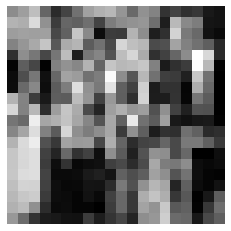

In [8]:
#@title Preparar imágenes
def plot_image(imag):
  if image_dimensions[2]==1:
    plt.imshow((imag*255).reshape(image_dimensions[0], image_dimensions[1]).astype(np.uint8))
    plt.gray()
  else:
    plt.imshow((imag*255).reshape(image_dimensions).astype(np.uint8))
  plt.axis("off")  

def prepare_images_list(image_list):    
  arr = np.array(image_list).astype('float32') / 255.
  arr = arr.reshape((len(arr), inputs_q))  
  return np.array(arr)

def prepare_classes_list(classesList, mapping_dict = None):
  if mapping_dict == None:
    dict_aux = list(set(classesList))
    mapping_dict = dict( zip( dict_aux, range(len(dict_aux)) ) )
  
  y = []
  for cl in classesList:
      y.append( mapping_dict[cl] )
  
  dummy_y = np_utils.to_categorical(y)
  return np.array(y), np.array(dummy_y), mapping_dict

input_training = prepare_images_list(images_train)
input_testing = prepare_images_list(images_test)

classes_training, classes_training_enc, mapping_dict = prepare_classes_list(classes_train)
classes_testing, classes_testing_enc, _ = prepare_classes_list(classes_test, mapping_dict)

classes_map = [ x for x,y in mapping_dict.items() ]

print("> Para Entrenamiento: ")
print(" - input_training (cant ejemplos, datos entrada): ", input_training.shape)
if softmax_output_flag:
  print(" - classes_training_enc (cant): ", len(classes_training_enc))
else:
  print(" - classes_training (cant): ", len(classes_training))
print("\n\n> Para Prueba: ")
print(" - input_testing (cant ejemplos, datos entrada): ", input_testing.shape)
if softmax_output_flag:
  print(" - classes_testing_enc (cant): ", len(classes_testing_enc))
else:
  print(" - classes_testing (cant): ", len(classes_testing))
print("\n\n> Para Ambos: ")
print(" - mapping_dict: ", mapping_dict)
print(" - classes_map: ", classes_map)
if len(classes_training)>0:
  print("\n - Imagen reconstruida de ", classes_map[classes_training[0]],  "(", classes_training[0], " / ", classes_training_enc[0], ")")
  plot_image(input_training[0])

In [10]:
#@title Establecer modelo

input_layer = Input(shape=(inputs_q,), name='input_img') # capa de entrada
each_layer_it = input_layer
aux_name = 'hidd_'
aux_id = 1 
for hidden_layer in hidden_layers:  
    auxlayerName = aux_name + str(aux_id)
    aux_id = aux_id + 1
    each_layer_it = Dense(hidden_layer, activation="sigmoid", name=auxlayerName)(each_layer_it)

if softmax_output_flag:
    output_layer = Dense(units = len(mapping_dict), activation='softmax', name='output')(each_layer_it)
else:
    output_layer = Dense(1, activation=None, name='output')(each_layer_it)


opt = keras.optimizers.Adam(learning_rate=nn_learning_rate)

model = Model(input_layer, output_layer, name='RNA')
if softmax_output_flag:
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
else:
    model.compile(optimizer=opt, loss='mse', metrics=['accuracy'])

print("Modelo creado con ", len(model.layers), " capas:")
model.summary()

Modelo creado con  4  capas:
Model: "RNA"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 400)]             0         
_________________________________________________________________
hidd_1 (Dense)               (None, 200)               80200     
_________________________________________________________________
hidd_2 (Dense)               (None, 50)                10050     
_________________________________________________________________
output (Dense)               (None, 2)                 102       
Total params: 90,352
Trainable params: 90,352
Non-trainable params: 0
_________________________________________________________________


In [11]:
#@title Entrenar

training_cases, validation_cases, y_t, y_v = train_test_split(
  input_training, 
  (classes_training_enc if softmax_output_flag else classes_training), 
  test_size=0.1
)

print("\n> De los ", len(input_training), "ejemplos de entrenamiento: ")
print("            se usan ", len(training_cases), "ejemplos para entrenar ")
print("            y ", len(validation_cases), "ejemplos para validar.")

print("\n\n>Comienza el Entrenamiento:")

# lleva a cabo el entrenamiento
history = model.fit(
  training_cases, y_t,
  epochs = nn_epochs, 
  validation_data=(validation_cases, y_v,)
) 

print("\n>Entrenamiento Finalizado.")


> De los  41 ejemplos de entrenamiento: 
            se usan  36 ejemplos para entrenar 
            y  5 ejemplos para validar.


>Comienza el Entrenamiento:
Epoch 1/50
2/2 [==============================] - 15s 569ms/step - loss: 0.9293 - accuracy: 0.4236 - val_loss: 0.9751 - val_accuracy: 0.4000
Epoch 2/50
2/2 [==============================] - 0s 26ms/step - loss: 0.7796 - accuracy: 0.5394 - val_loss: 0.6746 - val_accuracy: 0.6000
Epoch 3/50
2/2 [==============================] - 0s 25ms/step - loss: 0.7245 - accuracy: 0.4711 - val_loss: 0.7252 - val_accuracy: 0.6000
Epoch 4/50
2/2 [==============================] - 0s 25ms/step - loss: 0.8532 - accuracy: 0.4711 - val_loss: 0.6846 - val_accuracy: 0.6000
Epoch 5/50
2/2 [==============================] - 0s 24ms/step - loss: 0.7687 - accuracy: 0.4606 - val_loss: 0.6849 - val_accuracy: 0.6000
Epoch 6/50
2/2 [==============================] - 0s 26ms/step - loss: 0.6875 - accuracy: 0.5185 - val_loss: 0.7282 - val_accuracy: 0.4000
Epoc

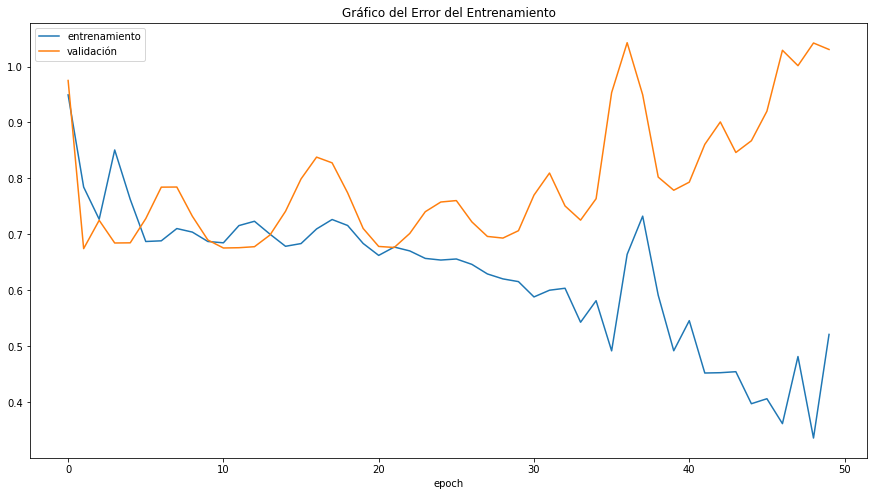

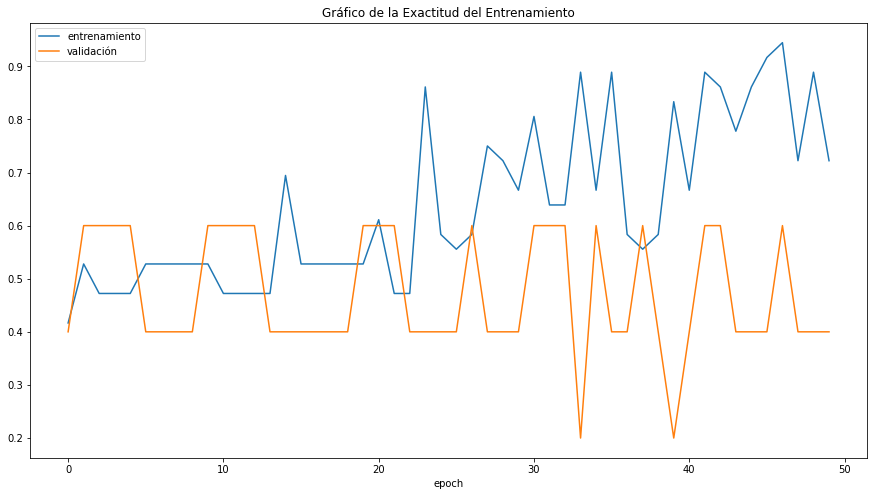

In [12]:
#@title Mostrar Gráficos del Entrenamiento
plt.figure(figsize=(15,8)) 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Gráfico del Error del Entrenamiento')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['entrenamiento', 'validación'], loc='upper left')
plt.show()

plt.figure(figsize=(15,8)) 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Gráfico de la Exactitud del Entrenamiento')
plt.ylabel('')
plt.xlabel('epoch')
plt.legend(['entrenamiento', 'validación'], loc='upper left')
plt.show()

*** Resultados con datos de Entrenamiento: 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



 Reporte de Clasificación: 
                 precision    recall  f1-score   support

  NO_WHEELCHAIR       0.86      0.86      0.86        21
WITH_WHEELCHAIR       0.85      0.85      0.85        20

       accuracy                           0.85        41
      macro avg       0.85      0.85      0.85        41
   weighted avg       0.85      0.85      0.85        41


Matriz de Confusión: 


,p:NO_WHEELCHAIR,p:WITH_WHEELCHAIR
r:NO_WHEELCHAIR,18,3
r:WITH_WHEELCHAIR,3,17





>Resultados: 


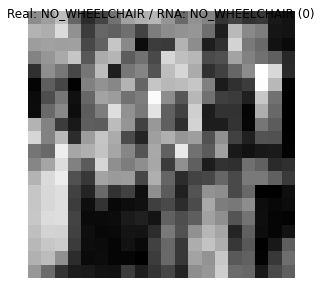

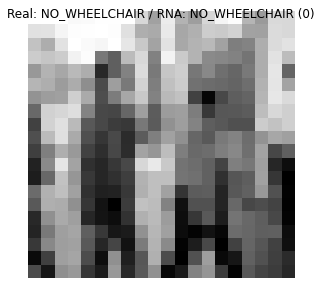

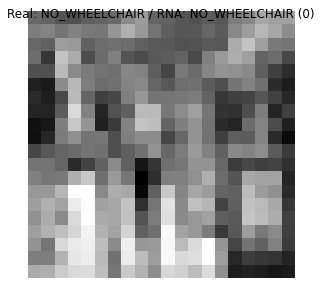

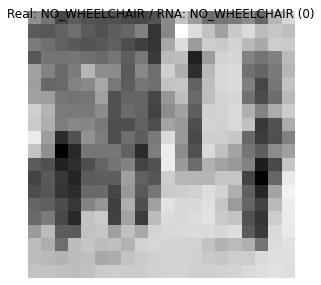

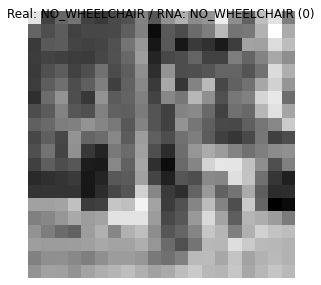

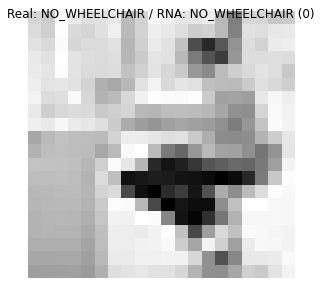

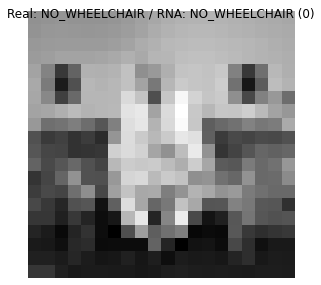

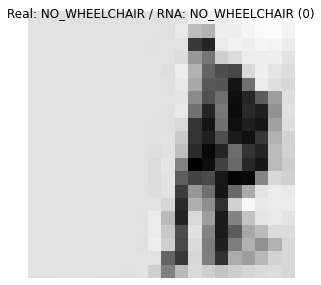

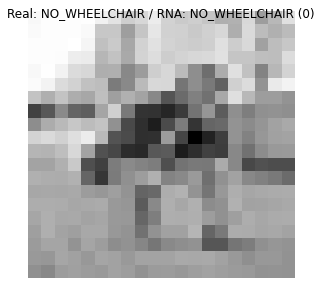

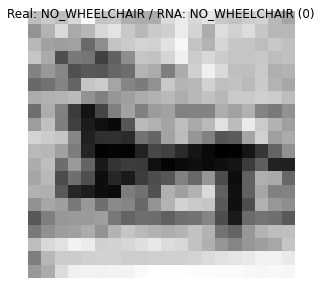

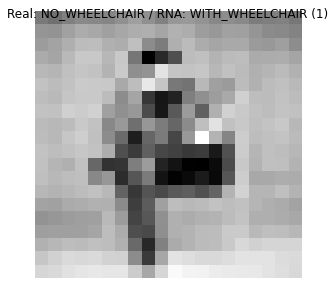

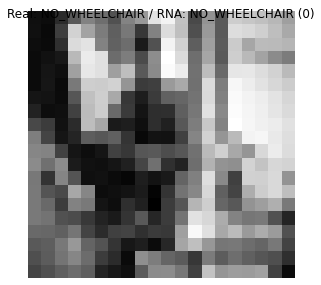

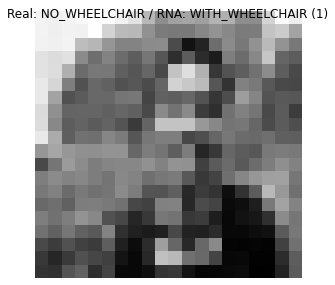

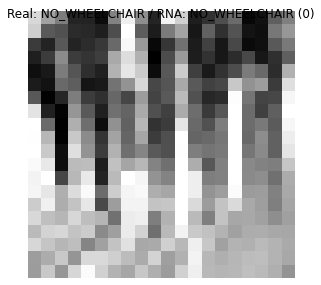

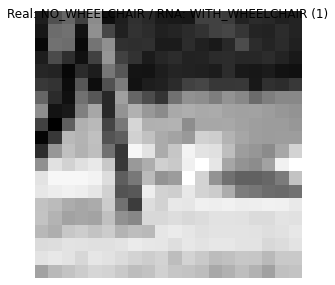

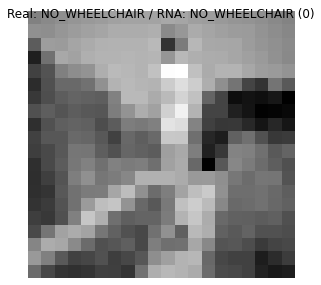

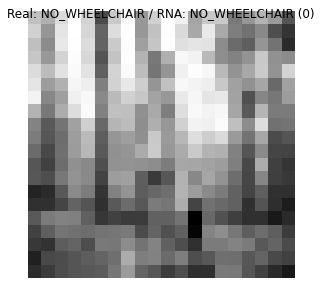

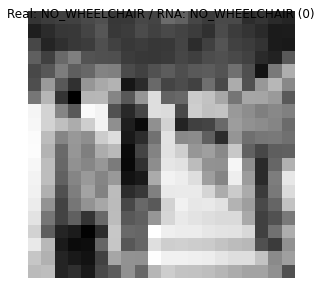

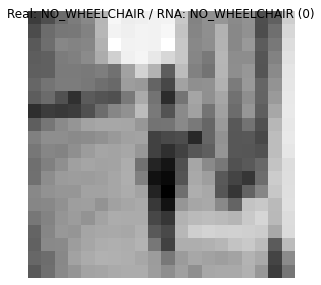

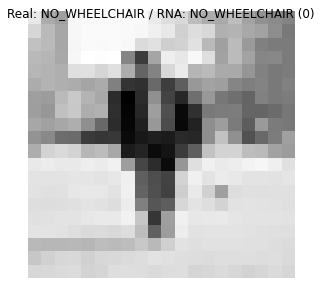

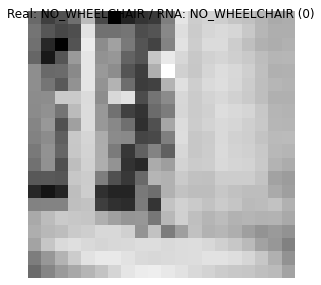

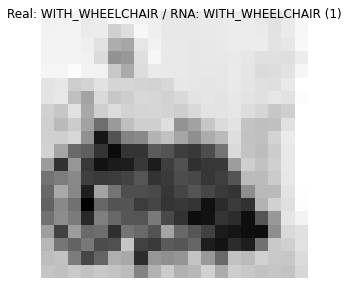

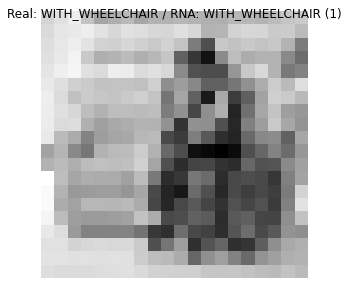

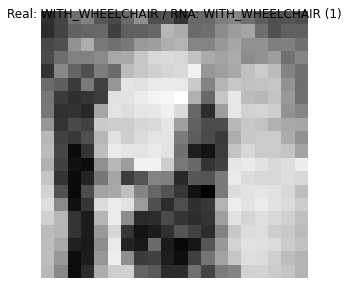

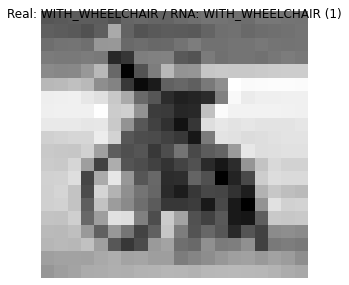

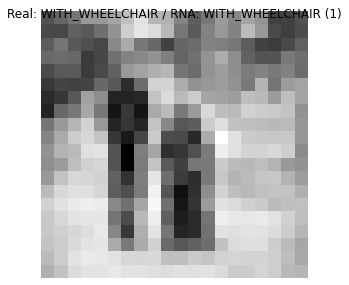

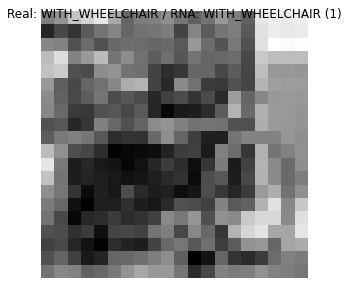

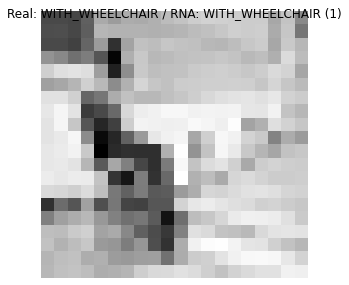

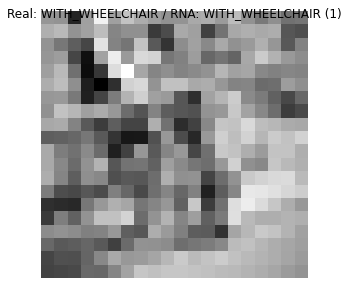

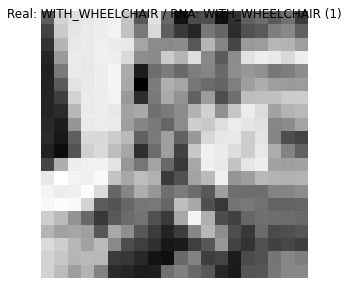

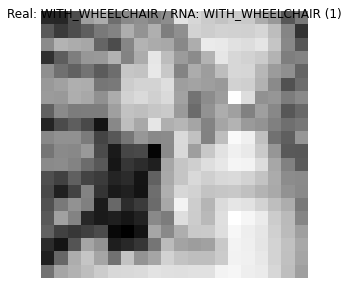

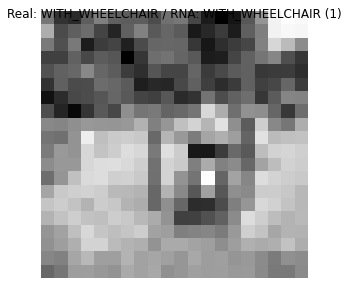

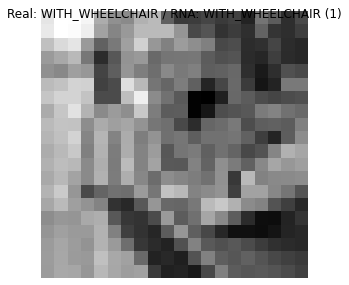

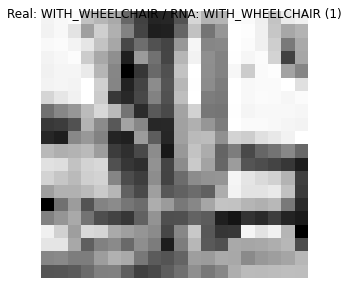

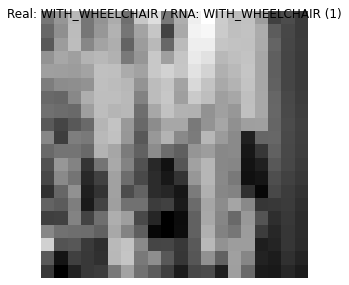

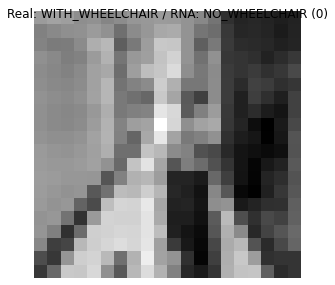

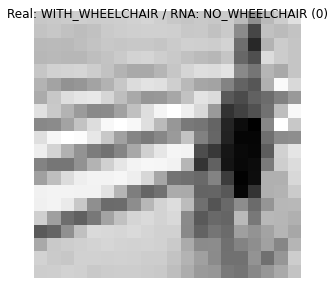

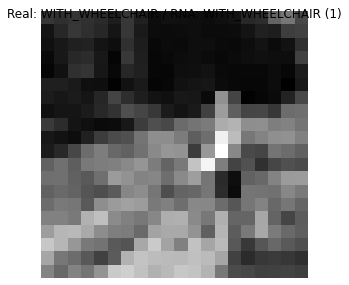

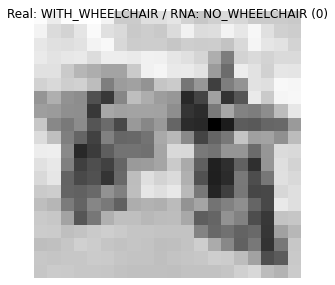

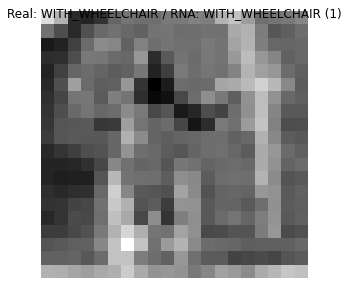

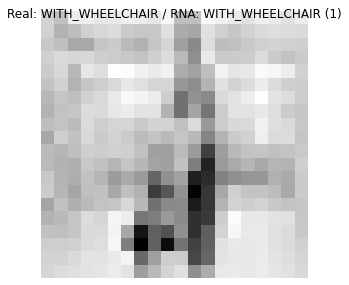

In [13]:
#@title Probar red entrenada con datos de entrenamiento

debug_image_details = True

def test_model(x, y, da_flag, classes_map, display_images = True):
    obtained_classes = model.predict(x)

    class_threshold = 0.5
    predicted_classes = []
    real_classes = []
    for i in range(len(x)):
        correct_class = classes_map[ y[i] ] 

        if softmax_output_flag:
            predicted_class_id = int( np.argmax(obtained_classes[i], axis=0) )
            predicted_class_id_final = predicted_class_id
        else:
            predicted_class_id = obtained_classes[i][0]       
            predicted_class_id_final = int(predicted_class_id)
            if (predicted_class_id - predicted_class_id_final)>0.5 and (predicted_class_id_final+1)<len(classes_map):
                    predicted_class_id_final = predicted_class_id_final + 1

        if predicted_class_id_final < 0 or predicted_class_id_final >= len(classes_map):
            predicted_class_name = "CLASE " + str(predicted_class_id_final) + " INVÁLIDA!"
        else:      
            predicted_class_name = classes_map[ predicted_class_id_final ]

        real_classes.append(correct_class)
        predicted_classes.append(predicted_class_name)

        plot_title = 'Real: ' + correct_class + ' / RNA: ' 
        plot_title = plot_title + predicted_class_name + ' (' + str( predicted_class_id ) +')'    

        if display_images:
            fig = plt.figure()
            fig.suptitle( plot_title )
            plot_image( x[i] )
            
            plt.tight_layout()
            fig = plt.gcf()

    print("\n Reporte de Clasificación: ")
    print(classification_report(real_classes, predicted_classes))

    print('\nMatriz de Confusión: ')
    cm = confusion_matrix(real_classes, predicted_classes, labels=classes_map)
    cmtx = pd.DataFrame(
      cm, 
      index=['r:{:}'.format(x) for x in classes_map], 
      columns=['p:{:}'.format(x) for x in classes_map]
    )
    cmtx = cmtx.sort_index()
    cols = list(cmtx.columns.values)
    cols.sort()
    display(cmtx[cols])
    print("\n")
    
    if display_images:
      print("\n>Resultados: ")


print("*** Resultados con datos de Entrenamiento: ")
test_model(input_training, classes_training, da_flag_train, classes_map, debug_image_details)

2/2 [==============================] - 0s 7ms/step - loss: 0.3924 - accuracy: 0.8537

>Evaluación del Modelo: 
    - Error:  0.39235976338386536
    - Exactitud:  85.36585569381714




*** Resultados con datos de Prueba: 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



 Reporte de Clasificación: 
                 precision    recall  f1-score   support

  NO_WHEELCHAIR       0.86      0.86      0.86        21
WITH_WHEELCHAIR       0.85      0.85      0.85        20

       accuracy                           0.85        41
      macro avg       0.85      0.85      0.85        41
   weighted avg       0.85      0.85      0.85        41


Matriz de Confusión: 


,p:NO_WHEELCHAIR,p:WITH_WHEELCHAIR
r:NO_WHEELCHAIR,18,3
r:WITH_WHEELCHAIR,3,17





>Resultados: 


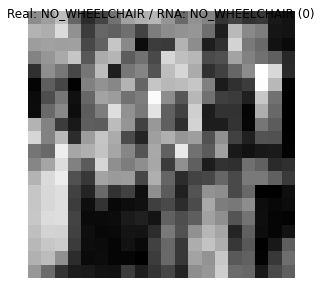

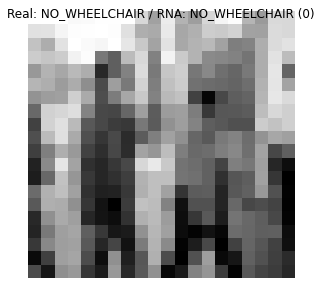

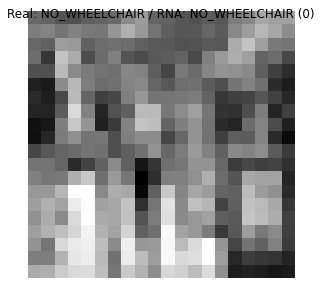

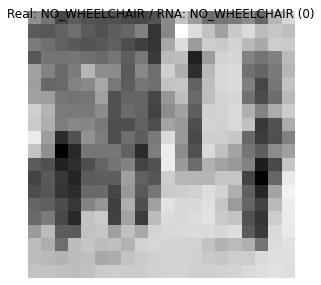

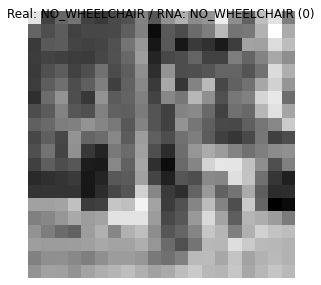

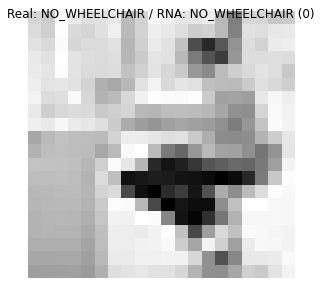

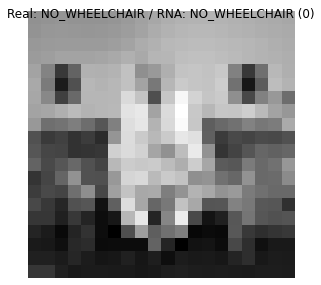

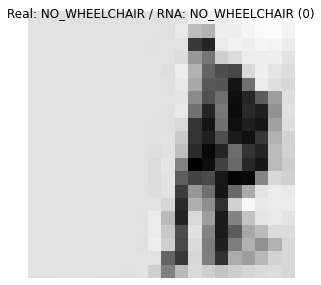

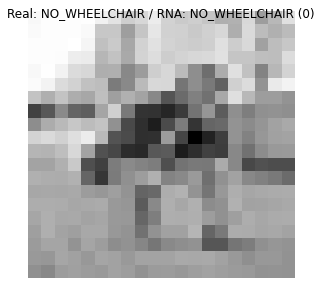

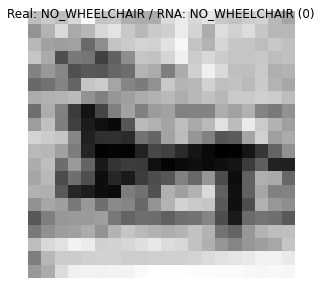

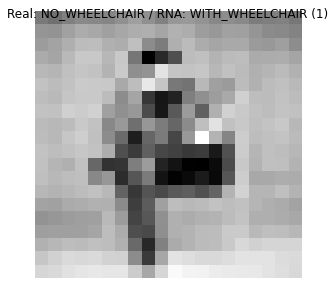

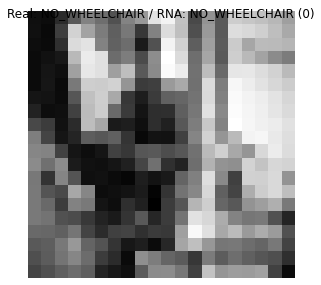

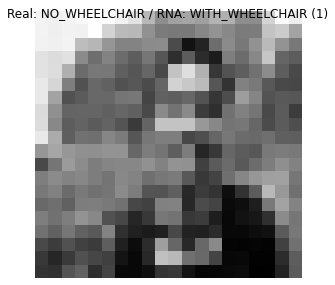

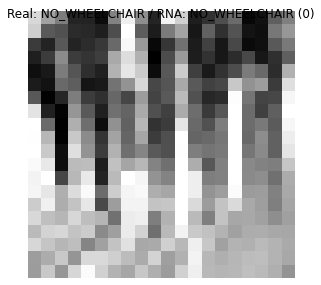

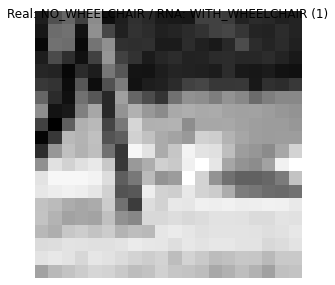

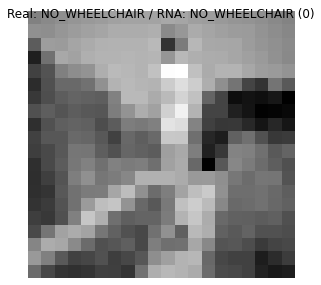

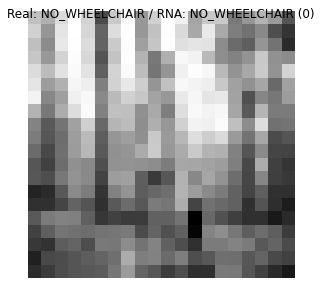

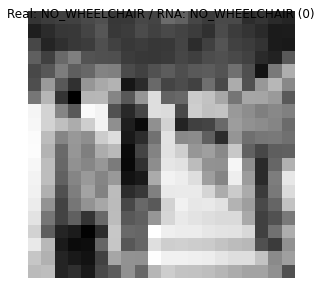

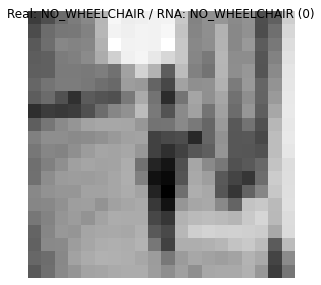

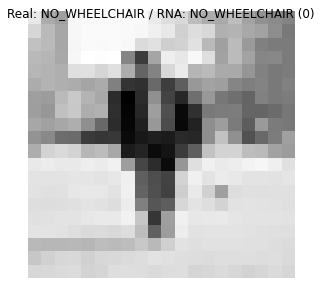

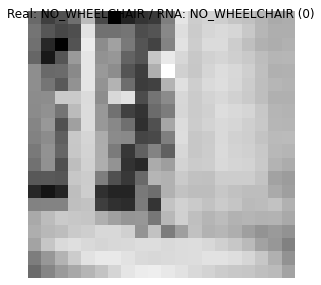

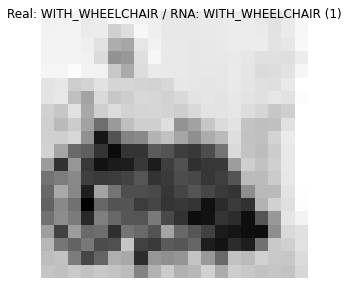

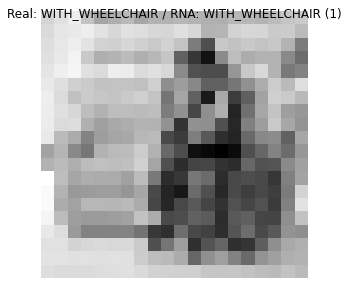

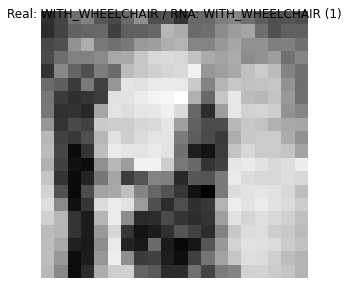

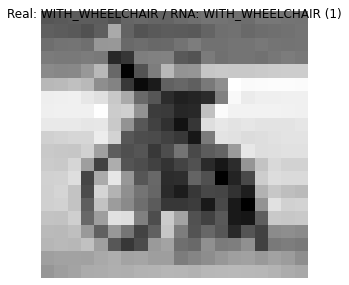

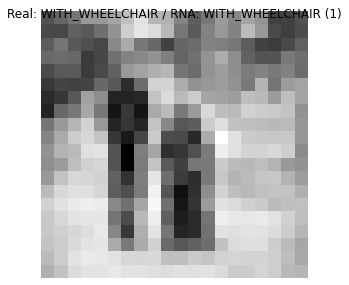

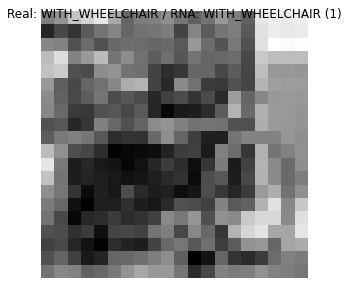

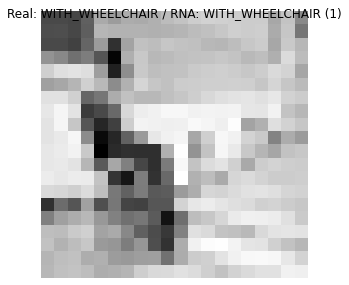

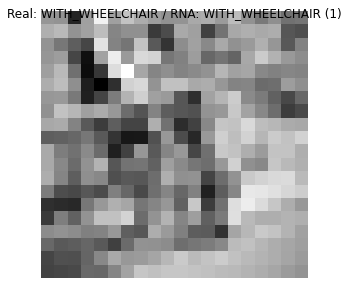

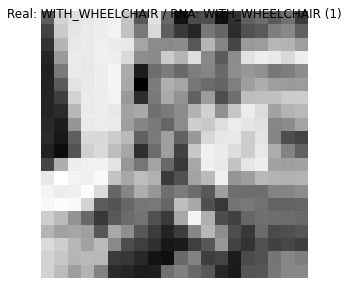

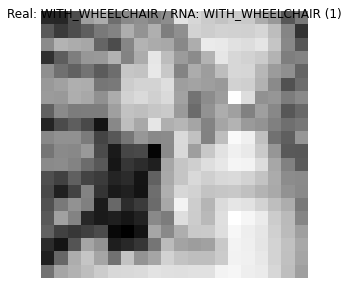

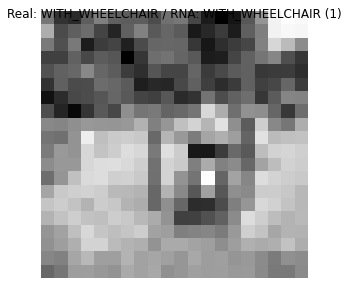

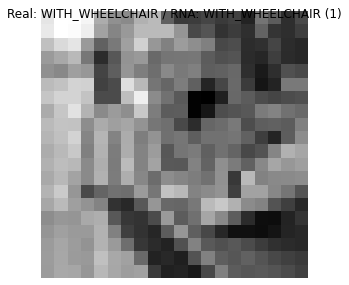

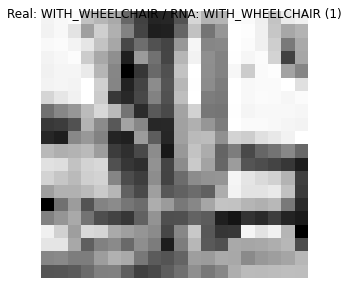

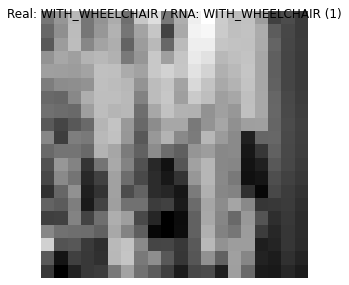

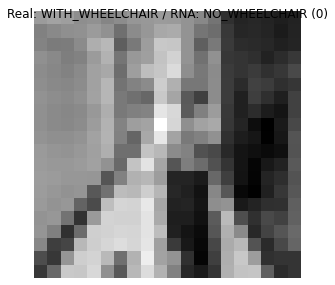

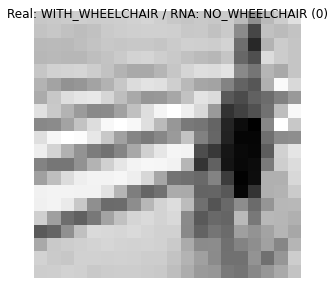

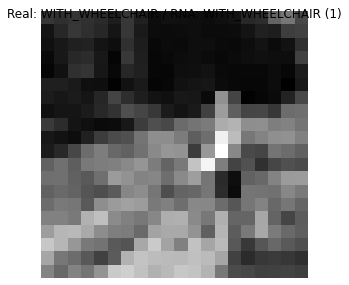

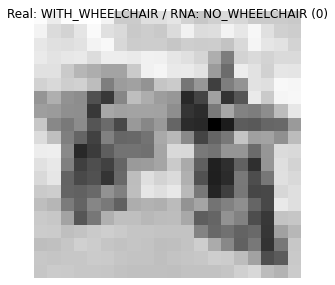

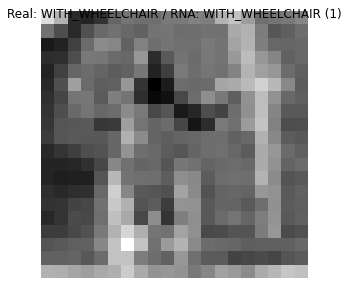

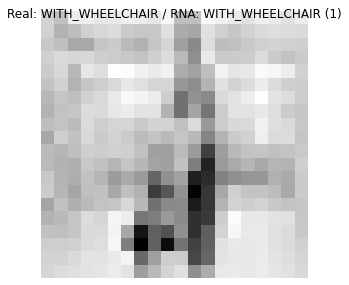

In [14]:
#@title Probar red entrenada con datos de prueba
 
debug_image_details = True

run_result = model.evaluate(input_testing, (classes_testing_enc if softmax_output_flag else classes_testing),)
print("\n>Evaluación del Modelo: ")
print("    - Error: ", run_result[0])
print("    - Exactitud: ", run_result[1] * 100)
print("\n")

print("\n\n*** Resultados con datos de Prueba: ")
test_model(input_testing, classes_testing, da_flag_test, classes_map, debug_image_details)